# Energy conserving network in tf.keras

This is using https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/005_Predicting_convective_and_radiative_heating_profiles.ipynb



In [1]:
%load_ext autoreload
%autoreload 2

In [242]:
from cbrain.imports import *

## Preprocess 

In [3]:
!python ../../preprocessing.py -c ../../pp_config/002_32col_tom.yml

2019-03-30 09:34:54.581727: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2019-03-30 09:34:54.686769: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1432] Found device 0 with properties: 
name: GeForce GTX 1080 major: 6 minor: 1 memoryClockRate(GHz): 1.7335
pciBusID: 0000:b3:00.0
totalMemory: 7.93GiB freeMemory: 6.29GiB
2019-03-30 09:34:54.686804: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1511] Adding visible gpu devices: 0
2019-03-30 09:34:55.128120: I tensorflow/core/common_runtime/gpu/gpu_device.cc:982] Device interconnect StreamExecutor with strength 1 edge matrix:
2019-03-30 09:34:55.128161: I tensorflow/core/common_runtime/gpu/gpu_device.cc:988]      0 
2019-03-30 09:34:55.128168: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1001] 0:   N 
2019-03-30 09:34:55.128495: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] Created TensorF

## Output normalization using Pressure levels

Using the dict normalizer

In [15]:
out_vars = ['PHQ', 'PHCLDLIQ', 'PHCLDICE', 'TPHYSTND', 'QRL', 'QRS', 'DTVKE', 
            'FSNT', 'FSNS', 'FLNT', 'FLNS', 'PRECT', 'PRECTEND', 'PRECST', 'PRECSTEN']

In [16]:
from cbrain.cam_constants import *

In [17]:
scale_dict = {
    'PHQ': L_V/G, 
    'PHCLDLIQ': L_V/G, 
    'PHCLDICE': L_V/G, 
    'TPHYSTND': C_P/G, 
    'QRL': C_P/G, 
    'QRS': C_P/G, 
    'DTVKE': C_P/G, 
    'FSNT': 1, 
    'FSNS': 1, 
    'FLNT': 1, 
    'FLNS': 1, 
    'PRECT': RHO_L*L_V, 
    'PRECTEND': 1e-3*RHO_L*L_V, 
    'PRECST': RHO_L*L_V, 
    'PRECSTEN': 1e-3*RHO_L*L_V
}

In [18]:
with open(os.path.join(os.path.dirname('../../cbrain/'), 'hyai_hybi.pkl'), 'rb') as f:
    hyai, hybi = pickle.load(f)

In [19]:
# Takes representative value for PS since purpose is normalization
PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
dP = P[1:]-P[:-1]; # Differential pressure [Pa]  

In [20]:
dP.shape

(30,)

In [21]:
for v in ['PHQ', 'PHCLDLIQ', 'PHCLDICE', 'TPHYSTND', 'QRL', 'QRS']:
    scale_dict[v] *= dP
scale_dict['DTVKE'] *= (dP/DT)

In [22]:
from cbrain.data_generator import DataGenerator
from cbrain.normalization import DictNormalizer

In [23]:
in_vars = ['QBP', 'QCBP', 'QIBP', 'TBP', 'VBP', 'PS', 'SOLIN', 'SHFLX', 'LHFLX']

In [26]:
train_gen.data_ds.close()

In [27]:
train_gen = DataGenerator(
    data_fn = '/local/S.Rasp/preprocessed_data/002_train.nc',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = '/local/S.Rasp/preprocessed_data/002_norm.nc',
    input_transform = 'max_rs',
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True
)

In [28]:
X, Y = train_gen[0]

In [29]:
X.shape, Y.shape

((1024, 154), (1024, 218))

(1e-06, 1000.0)

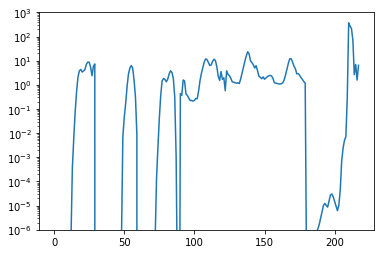

In [118]:
plt.plot(np.mean(np.abs(Y), 0))
plt.yscale('log')
plt.ylim(1e-6, 1e3)

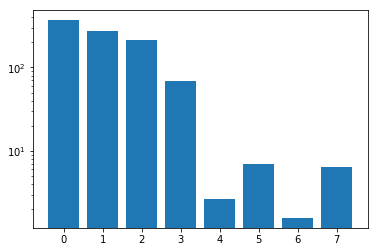

In [120]:
plt.bar(range(8), np.mean(np.abs(Y), 0)[-8:])
plt.yscale('log')

## Build the model

### Radiation conservation layer

In [70]:
train_gen.input_idxs.var_names[train_gen.input_idxs]

<xarray.DataArray 'var_names' (var_names: 154)>
array(['QBP', 'QBP', 'QBP', 'QBP', 'QBP', 'QBP', 'QBP', 'QBP', 'QBP', 'QBP',
       'QBP', 'QBP', 'QBP', 'QBP', 'QBP', 'QBP', 'QBP', 'QBP', 'QBP', 'QBP',
       'QBP', 'QBP', 'QBP', 'QBP', 'QBP', 'QBP', 'QBP', 'QBP', 'QBP', 'QBP',
       'QCBP', 'QCBP', 'QCBP', 'QCBP', 'QCBP', 'QCBP', 'QCBP', 'QCBP', 'QCBP',
       'QCBP', 'QCBP', 'QCBP', 'QCBP', 'QCBP', 'QCBP', 'QCBP', 'QCBP', 'QCBP',
       'QCBP', 'QCBP', 'QCBP', 'QCBP', 'QCBP', 'QCBP', 'QCBP', 'QCBP', 'QCBP',
       'QCBP', 'QCBP', 'QCBP', 'QIBP', 'QIBP', 'QIBP', 'QIBP', 'QIBP', 'QIBP',
       'QIBP', 'QIBP', 'QIBP', 'QIBP', 'QIBP', 'QIBP', 'QIBP', 'QIBP', 'QIBP',
       'QIBP', 'QIBP', 'QIBP', 'QIBP', 'QIBP', 'QIBP', 'QIBP', 'QIBP', 'QIBP',
       'QIBP', 'QIBP', 'QIBP', 'QIBP', 'QIBP', 'QIBP', 'TBP', 'TBP', 'TBP',
       'TBP', 'TBP', 'TBP', 'TBP', 'TBP', 'TBP', 'TBP', 'TBP', 'TBP', 'TBP',
       'TBP', 'TBP', 'TBP', 'TBP', 'TBP', 'TBP', 'TBP', 'TBP', 'TBP', 'TBP',
       'TBP', 'TB

In [31]:
tf.enable_eager_execution()

In [32]:
from cbrain.utils import return_var_idxs

In [123]:
import tensorflow as tf
import tensorflow.math as tfm
from tensorflow import keras
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K

In [46]:
inp_layer = Input(shape=(154,))
out_layer = Dense(218, activation='elu')(inp_layer)
model = keras.models.Model(inp_layer, out_layer)

In [39]:
in_vars

['QBP', 'QCBP', 'QIBP', 'TBP', 'VBP', 'PS', 'SOLIN', 'SHFLX', 'LHFLX']

In [41]:
print(out_vars)

['PHQ', 'PHCLDLIQ', 'PHCLDICE', 'TPHYSTND', 'QRL', 'QRS', 'DTVKE', 'FSNT', 'FSNS', 'FLNT', 'FLNS', 'PRECT', 'PRECTEND', 'PRECST', 'PRECSTEN']


In [67]:
inp_vars_full = train_gen.norm_ds.var_names[train_gen.input_idxs]

In [124]:
out_vars_full = train_gen.norm_ds.var_names[train_gen.output_idxs]

In [336]:
def return_var_slice(var_names, var):
    var_idxs = np.atleast_1d(np.squeeze(np.where(var_names == var)))
    return slice(int(var_idxs[0]), int(var_idxs[-1])+1)

In [337]:
def compute_dP_tilde(PS, hyai, hybi, PS_div, PS_sub, norm_q):
    """
    Computes dP_tilde in Tom's notation.
    PS is the normalized pressure as it is used in the input.
    PS_mult and PS_add are the corresponding values to unnormalize PS.
    WARNING: Really not sure about norm_q
    """
    PS = PS * PS_div + PS_sub
    P = P0 * hyai + PS[:, None] * hybi
    dP = P[:, 1:] - P[:, :-1]
    dP_norm = norm_q * G / L_V   # Why L_V?
    dP_tilde = dP / dP_norm
    return dP_tilde

In [338]:
class SurRadLayer(Layer):
    def __init__(self, inp_div, inp_sub, norm_q, **kwargs):
        """
        Call using ([input, output])
        Assumes
        prior: [PHQ_nores, PHCLDLIQ, PHCLDICE, TPHYSTND_nores, 
        QRL, QRS, DTVKE, FSNT, FLNT, PRECT, PRECTEND, PRECST, PRECSTEN]
        Returns
        post(erior): [PHQ_nores, PHCLDLIQ, PHCLDICE, TPHYSTND_nores, 
        QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]
        """
        self.inp_div, self.inp_sub, self.norm_q = inp_div, inp_sub, norm_q
        # Define variable indices here
        self.PS_idx = 150
        self.QRL_idx = slice(118, 148)  # Odd numbers because residuals
        self.QRS_idx = slice(148, 178)  # for Q and T are still missing
        self.FSNT_idx = 208
        self.FLNT_idx = 209
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        super().build(input_shape)
        
    def call(self, arrs):
        inp, prior = arrs
        
        # 1. Compute dP_tilde
        dP_tilde = compute_dP_tilde(
            inp[:, self.PS_idx], hyai, hybi, 
            self.inp_div[self.PS_idx], self.inp_sub[self.PS_idx],
            self.norm_q
        )
        
        # 2. Compute radiative integrals
        SWINT = K.sum(dP_tilde * prior[:, self.QRS_idx], 1)
        LWINT = K.sum(dP_tilde * prior[:, self.QRL_idx], 1)
        
        # 3. Infer surface fluxes from residual
        FSNS = prior[:, self.FSNT_idx] - SWINT
        FLNS = prior[:, self.FLNT_idx] + LWINT
        
        # 4. Concatenate output vector
        post = tf.concat([
            prior[:, :self.FLNT_idx], FSNS[:, None], 
            prior[:, self.FSNT_idx][:, None], FLNS[:, None],
            prior[:, (self.FLNT_idx+1):]
        ], axis=1)
        return post
    
    def compute_output_shape(self, input_shape):
        """Input shape + 2"""
        return (input_shape[0][0], input_shape[0][1] + 2)

In [340]:
inp_layer = Input(shape=(154,))
x = Dense(214, activation='elu')(inp_layer)
out_layer = SurRadLayer(
    inp_div=train_gen.input_transform.maxrs,
    inp_sub=train_gen.input_transform.mean,
    norm_q=train_gen.output_transform.scale[:30]
)([inp_layer, x])
model = keras.models.Model(inp_layer, out_layer)

#### Test 

In [341]:
# Create a fake output vector with the correct values
Y.shape

(1024, 218)

In [342]:
Y_fake = tf.concat(
    [Y[:, 0:29], Y[:, 30:119], Y[:, 120:211], Y[:, 212:213], Y[:, 214:]], 1
)

In [343]:
ll = model.layers[-1]

In [344]:
out_fake = ll([X, Y_fake])

In [345]:
out_fake.shape

TensorShape([Dimension(1024), Dimension(216)])

In [346]:
FSNS_fake = out_fake[:, 211].numpy()

In [347]:
FSNS_true = Y[:, 213]

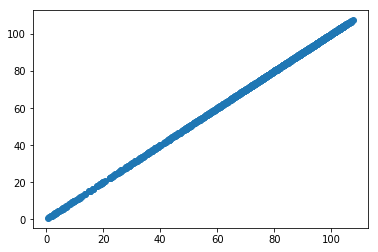

In [348]:
plt.scatter(FSNS_fake, FSNS_true)

### Mass conservation layer

In [349]:
return_var_slice(inp_vars_full, 'LHFLX')

slice(153, 154, None)

In [350]:
class MassConsLayer(Layer):
    def __init__(self, inp_div, inp_sub, norm_q, **kwargs):
        """
        Call using ([input, output])
        Assumes
        prior: [PHQ_nores, PHCLDLIQ, PHCLDICE, TPHYSTND_nores, 
        QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]
        Returns
        post(erior): [PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND_nores, 
        QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]
        """
        self.inp_div, self.inp_sub, self.norm_q = inp_div, inp_sub, norm_q
        # Define variable indices here
        # Input
        self.PS_idx = 150
        self.LHFLX_idx = 153
        # Output
        self.PHQ_idx = slice(0, 29)   # Residual still missing
        self.PHCLDLIQ_idx = slice(29, 59)
        self.PHCLDICE_idx = slice(59, 89)
        self.PRECT_idx = 212
        self.PRECTEND_idx = 213
        
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        super().build(input_shape)
        
    def call(self, arrs):
        inp, prior = arrs

        # 1. Compute dP_tilde
        dP_tilde = compute_dP_tilde(
            inp[:, self.PS_idx], hyai, hybi, 
            self.inp_div[self.PS_idx], self.inp_sub[self.PS_idx],
            self.norm_q
        )
        
        # 2. Compute vertical cloud water integral
        CLDINT = K.sum(dP_tilde * 
            (prior[:, self.PHCLDLIQ_idx] + prior[:, self.PHCLDICE_idx]), 
        axis=1)
        
        # 3. Compute water vapor integral
        VAPINT = K.sum(dP_tilde[:, :29] * prior[:, self.PHQ_idx], 1)
        
        # 4. Compute forcing (see Tom's note for details, I am just copying)
        LHFLX = (inp[:, self.LHFLX_idx] * self.inp_div[self.LHFLX_idx] + 
                 self.inp_sub[self.LHFLX_idx])
        PREC = prior[:, self.PRECT_idx] + prior[:, self.PRECTEND_idx]
        
        # 5. Compute water vapor tendency at level 30 as residual
        PHQ30 = (LHFLX - PREC - CLDINT - VAPINT) / dP_tilde[:, 29]
        
        # 6. Concatenate output vector
        post = tf.concat([
            prior[:, self.PHQ_idx], PHQ30[:, None], 
            prior[:, 29:]
        ], axis=1)
        return post
    
    def compute_output_shape(self, input_shape):
        """Input shape + 1"""
        return (input_shape[0][0], input_shape[0][1] + 1)

#### Test

In [351]:
inp_layer = Input(shape=(154,))
x = Dense(214, activation='elu')(inp_layer)
x = SurRadLayer(
    inp_div=train_gen.input_transform.maxrs,
    inp_sub=train_gen.input_transform.mean,
    norm_q=train_gen.output_transform.scale[:30]
)([inp_layer, x])
out_layer = MassConsLayer(
    inp_div=train_gen.input_transform.maxrs,
    inp_sub=train_gen.input_transform.mean,
    norm_q=train_gen.output_transform.scale[:30]
)([inp_layer, x])
model = keras.models.Model(inp_layer, out_layer)

In [352]:
ll = model.layers[-1]

In [353]:
out_fake2 = ll([X, out_fake])

In [354]:
out_fake2.shape

TensorShape([Dimension(1024), Dimension(217)])

In [355]:
PHQ30_fake = out_fake2[:, 29].numpy()

In [356]:
PHQ30_true = Y[:, 29]

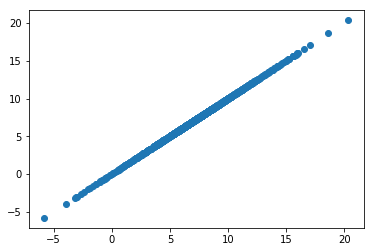

In [357]:
plt.scatter(PHQ30_fake, PHQ30_true)

### Enthalpy conservation

In [358]:
class EntConsLayer(Layer):
    def __init__(self, inp_div, inp_sub, norm_q, **kwargs):
        """
        Call using ([input, output])
        Assumes
        prior: [PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND_nores, 
        QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]
        Returns
        post(erior): [PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND, 
        QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]
        """
        self.inp_div, self.inp_sub, self.norm_q = inp_div, inp_sub, norm_q
        # Define variable indices here
        # Input
        self.PS_idx = 150
        self.SHFLX_idx = 152
        self.LHFLX_idx = 153
        
        # Output
        self.PHQ_idx = slice(0, 30)
        self.PHCLDLIQ_idx = slice(30, 60)
        self.TPHYSTND_idx = slice(90, 119)  # Residual still missing
        self.DTVKE_idx = slice(179, 209)
        self.FSNT_idx = 209 
        self.FSNS_idx = 210
        self.FLNT_idx = 211
        self.FLNS_idx = 212
        self.PRECT_idx = 213
        self.PRECTEND_idx = 214
        self.PRECST_idx = 215
        self.PRECSTEND_idx = 216
        
        
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        super().build(input_shape)
        
    def call(self, arrs):
        inp, prior = arrs

        # 1. Compute dP_tilde
        dP_tilde = compute_dP_tilde(
            inp[:, self.PS_idx], hyai, hybi, 
            self.inp_div[self.PS_idx], self.inp_sub[self.PS_idx],
            self.norm_q
        )
        
        # 2. Compute net energy input from phase change and precipitation
        PHAS = L_I / L_V * (
            (prior[:, self.PRECST_idx] + prior[:, self.PRECSTEND_idx]) - 
            (prior[:, self.PRECT_idx] + prior[:, self.PRECTEND_idx])
        )
        
        # 3. Compute net energy input from radiation, SHFLX and TKE
        RAD = (prior[:, self.FSNT_idx] - prior[:, self.FSNS_idx] - 
               prior[:, self.FLNT_idx] + prior[:, self.FLNS_idx])
        SHFLX = (inp[:, self.SHFLX_idx] * self.inp_div[self.SHFLX_idx] + 
                 self.inp_sub[self.SHFLX_idx])
        KEDINT = K.sum(dP_tilde * prior[:, self.DTVKE_idx], 1)
        
        # 4. Compute tendency of vapor due to phase change
        LHFLX = (inp[:, self.LHFLX_idx] * self.inp_div[self.LHFLX_idx] + 
                 self.inp_sub[self.LHFLX_idx])
        VAPINT = K.sum(dP_tilde * prior[:, self.PHQ_idx], 1)
        SPDQINT = (VAPINT - LHFLX) * L_S / L_V
        
        # 5. Same for cloud liquid water tendency
        SPDQCINT = K.sum(dP_tilde * prior[:, self.PHCLDLIQ_idx], 1) * L_I / L_V
        
        # 6. And the same for T but remember residual is still missing
        DTINT = K.sum(dP_tilde[:, :29] * prior[:, self.TPHYSTND_idx], 1)
        
        pdb.set_trace()
        # 7. Compute DT30 as residual
        DT30 = (
            PHAS + RAD + SHFLX + KEDINT - SPDQINT - SPDQCINT - DTINT
        ) / dP_tilde[:, 29]
        
        # 8. Concatenate output vector
        post = tf.concat([
            prior[:, :119], DT30[:, None], prior[:, 119:]
        ], axis=1)
        return post
    
    def compute_output_shape(self, input_shape):
        """Input shape + 1"""
        return (input_shape[0][0], input_shape[0][1] + 1)

In [359]:
L_I

333700.0

#### Test

In [379]:
inp_layer = Input(shape=(154,))
x = Dense(214, activation='elu')(inp_layer)
x = SurRadLayer(
    inp_div=train_gen.input_transform.maxrs,
    inp_sub=train_gen.input_transform.mean,
    norm_q=train_gen.output_transform.scale[:30]
)([inp_layer, x])
x = MassConsLayer(
    inp_div=train_gen.input_transform.maxrs,
    inp_sub=train_gen.input_transform.mean,
    norm_q=train_gen.output_transform.scale[:30]
)([inp_layer, x])
out_layer = EntConsLayer(
    inp_div=train_gen.input_transform.maxrs,
    inp_sub=train_gen.input_transform.mean,
    norm_q=train_gen.output_transform.scale[:30]
)([inp_layer, x])
model = keras.models.Model(inp_layer, out_layer)

In [380]:
ll = model.layers[-1]

In [381]:
out_fake3 = ll([X, out_fake2])

> <ipython-input-358-593de1bb0c0f>(77)call()
-> PHAS + RAD + SHFLX + KEDINT - SPDQINT - SPDQCINT - DTINT
(Pdb) q


BdbQuit: 

In [363]:
out_fake3.shape

TensorShape([Dimension(1024), Dimension(218)])

In [364]:
DT30_fake = out_fake3[:, 119].numpy()

In [365]:
DT30_true = Y[:, 119]

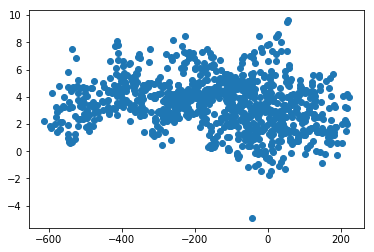

In [366]:
plt.scatter(DT30_fake, DT30_true)

In [321]:
class EntConsLay2(Layer):
    
    def __init__(self, fsub, fdiv, normq, output_dim, **kwargs):
        self.fsub = fsub # Subtraction for normalization of inputs 
        self.fdiv = fdiv # Division for normalization of inputs
        self.normq = normq # Normalization of output's water concentration
        self.hyai = hyai # CAM constants to calculate d_pressure
        self.hybi = hybi # CAM constants to calculate d_pressure
        self.output_dim = output_dim # Dimension of output
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        super().build(input_shape)  # Be sure to call this somewhere!
        
    # tgb - 2/6/2019 - following https://github.com/keras-team/keras/issues/4871
    def get_config(self):
        config = {'fsub': list(self.fsub), 'fdiv': list(self.fdiv),
                  'normq': list(self.normq), 'hyai': list(self.hyai),
                  'hybi': list(self.hybi), 'output_dim': self.output_dim}
        base_config = super(EntConsLay, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
        
    def call(self, arrs):
        
        # Split between the inputs inp & the output of the densely connected
        # neural network, massout
        inp, massout = arrs
        
        # 0) Constants
        G = 9.80616; # Reference gravity constant [m.s-2]
        L_F = 3.337e5; # Latent heat of fusion of water [W.kg-1]
        L_V = 2.501e6; # Latent heat of vaporization of water [W.kg-1]
        P0 = 1e5; # Reference surface pressure [Pa]
        
        # 1) Get non-dimensional pressure differences (p_tilde above)
        # In the input vector, PS is the 151st element after 
        # the first elements = [QBP, ..., VBP with shape 30*5=150]
        PS = tfm.add( tfm.multiply( inp[:,150], self.fdiv[150]), self.fsub[150])
        # Reference for calculation of d_pressure is cbrain/models.py (e.g. QLayer)
        P = tfm.add( tfm.multiply( P0, self.hyai), \
                    tfm.multiply( PS[:,None], self.hybi))
        dP = tfm.subtract( P[:, 1:], P[:, :-1])
        # norm_output = dp_norm * L_V/G so dp_norm = norm_output * G/L_V
        dP_NORM = tfm.divide( \
                             tfm.multiply(self.normq[:30], \
                                          G),\
                             L_V)
        # dp_tilde = dp/dp_norm
        dP_TILD = tfm.divide( dP, dP_NORM)
        
        # 2) Calculate net energy input from phase change and precipitation
        # PHAS = Lf/Lv*((PRECST+PRECSTEN)-(PRECT+PRECTEND))
        PHAS = tfm.divide( tfm.multiply( tfm.subtract(\
                                                      tfm.add( massout[:,215], massout[:,216]),\
                                                      tfm.add( massout[:,213], massout[:,214])),\
                                        L_F),\
                          L_V)
        
        # 3) Calculate net energy input from radiation, sensible heat flux and turbulent KE
        # 3.1) RAD = FSNT-FSNS-FLNT+FLNS
        RAD = tfm.add(\
                      tfm.subtract( massout[:,209], massout[:,210]),\
                      tfm.subtract( massout[:,212], massout[:,211]))
        # 3.2) Unnormalize sensible heat flux
        SHF = tfm.add( tfm.multiply( inp[:,152], self.fdiv[152]), self.fsub[152])
        # 3.3) Net turbulent kinetic energy dissipative heating is the column-integrated 
        # turbulent kinetic energy energy dissipative heating
        # tgb - 3/20/2019 - Error here, it should be 
        KEDVEC = tfm.multiply( dP_TILD, massout[:, 179:209])
        KEDINT = tfm.reduce_sum( KEDVEC, axis=1)
        
        # 4) Calculate tendency of normalized column water vapor due to phase change
        # 4.1) Unnormalize latent heat flux
        LHF = tfm.add( tfm.multiply( inp[:,153], self.fdiv[153]), self.fsub[153])
        # 4.2) Column water vapor is the column integral of specific humidity
        PHQVEC = tfm.multiply( dP_TILD, massout[:, :30])
        PHQINT = tfm.reduce_sum( PHQVEC, axis=1)
        # 4.3) Multiply by L_S/L_V to normalize (explanation above)
        SPDQINT = tfm.divide( tfm.multiply( tfm.subtract(\
                                                         PHQINT, LHF),\
                                           L_S),\
                             L_V)
        
        # 5) Same operation for liquid water tendency but multiplied by L_F/L_V
        SPDQCINT = tfm.divide( tfm.multiply(\
                                            tfm.reduce_sum(\
                                                           tfm.multiply( dP_TILD, massout[:, 30:60]),\
                                                           axis=1),\
                                            L_F),\
                              L_V)
        
        # 6) Same operation for temperature but only integrate from level 1 to level 29
        DTINT = tfm.reduce_sum( tfm.multiply( dP_TILD[:, :29], massout[:, 90:119]), axis=1)
        
        pdb.set_trace()
        # 7) Now calculate dT30 as a residual
        dT30 = tfm.divide(tfm.add(tfm.add(tfm.add(tfm.add(tfm.add(tfm.add(\
                                                                          PHAS,RAD),\
                                                                  SHF),\
                                                          KEDINT),\
                                                  tfm.negative( SPDQINT)),\
                                          tfm.negative( SPDQCINT)),\
                                  tfm.negative( DTINT)),\
                          dP_TILD[:, 29])
        dT30 = tf.expand_dims(dT30,1)

        out = tf.concat([massout[:, :119], dT30, massout[:, 119:]], 1)
        return out
    
    def compute_output_shape(self, input_shape):
        # tgb - 2/7/2019 - Wrap the returned output shape in Tensorshape
        # to avoid problems with custom layers & eager execution
        # https://github.com/tensorflow/tensorflow/issues/20805
        return tf.TensorShape((input_shape[0][0], self.output_dim))
    # and is ready to be used in the cost function

In [382]:
inp_layer = Input(shape=(154,))
x = Dense(214, activation='elu')(inp_layer)
x = SurRadLayer(
    inp_div=train_gen.input_transform.maxrs,
    inp_sub=train_gen.input_transform.mean,
    norm_q=train_gen.output_transform.scale[:30]
)([inp_layer, x])
x = MassConsLayer(
    inp_div=train_gen.input_transform.maxrs,
    inp_sub=train_gen.input_transform.mean,
    norm_q=train_gen.output_transform.scale[:30]
)([inp_layer, x])
out_layer = EntConsLay2(
    fdiv=train_gen.input_transform.maxrs,
    fsub=train_gen.input_transform.mean,
    normq=scale_dict['PHQ'].astype(np.float32), output_dim=218
)([inp_layer, x])
model2 = keras.models.Model(inp_layer, out_layer)

In [387]:
train_gen.output_transform.scale[:30]

array([7.0811688e+07, 1.3074195e+08, 2.1416968e+08, 3.0895507e+08,
       3.8762454e+08, 4.4520458e+08, 4.4321341e+08, 3.6317274e+08,
       4.2725363e+08, 5.0264179e+08, 5.9133267e+08, 6.9567130e+08,
       8.1842189e+08, 9.6283091e+08, 1.1327208e+09, 1.3325876e+09,
       1.5677192e+09, 1.8443416e+09, 2.1697718e+09, 2.1706404e+09,
       1.9922214e+09, 1.6811766e+09, 1.2494747e+09, 7.2336026e+08,
       6.7864000e+08, 6.2842355e+08, 5.7302906e+08, 5.1279840e+08,
       4.4820285e+08, 3.7970432e+08], dtype=float32)

In [388]:
scale_dict['PHQ']

array([7.08116868e+07, 1.30741954e+08, 2.14169680e+08, 3.08955070e+08,
       3.87624540e+08, 4.45204562e+08, 4.43213412e+08, 3.63172740e+08,
       4.27253619e+08, 5.02641782e+08, 5.91332654e+08, 6.95671302e+08,
       8.18421887e+08, 9.62830941e+08, 1.13272077e+09, 1.33258767e+09,
       1.56771913e+09, 1.84434160e+09, 2.16977190e+09, 2.17064049e+09,
       1.99222141e+09, 1.68117657e+09, 1.24947462e+09, 7.23360228e+08,
       6.78639973e+08, 6.28423533e+08, 5.73029078e+08, 5.12798397e+08,
       4.48202842e+08, 3.79704310e+08])

In [383]:
ll2 = model2.layers[-1]

In [384]:
hyai = hyai.astype(np.float32)
hybi = hybi.astype(np.float32)

In [385]:
train_gen.output_transform.scale[:30]

array([7.0811688e+07, 1.3074195e+08, 2.1416968e+08, 3.0895507e+08,
       3.8762454e+08, 4.4520458e+08, 4.4321341e+08, 3.6317274e+08,
       4.2725363e+08, 5.0264179e+08, 5.9133267e+08, 6.9567130e+08,
       8.1842189e+08, 9.6283091e+08, 1.1327208e+09, 1.3325876e+09,
       1.5677192e+09, 1.8443416e+09, 2.1697718e+09, 2.1706404e+09,
       1.9922214e+09, 1.6811766e+09, 1.2494747e+09, 7.2336026e+08,
       6.7864000e+08, 6.2842355e+08, 5.7302906e+08, 5.1279840e+08,
       4.4820285e+08, 3.7970432e+08], dtype=float32)

In [386]:
out_fake32 = ll2([X, out_fake2])

> <ipython-input-321-c0dbd134a84f>(97)call()
-> dT30 = tfm.divide(tfm.add(tfm.add(tfm.add(tfm.add(tfm.add(tfm.add(\
(Pdb) LHF
<tf.Tensor: id=3591, shape=(1024,), dtype=float32, numpy=
array([10.795265 ,  9.885124 ,  9.976654 , ...,  5.9862595,  5.794075 ,
        7.4533844], dtype=float32)>
(Pdb) SHF
<tf.Tensor: id=3579, shape=(1024,), dtype=float32, numpy=
array([2.809968 , 2.6887646, 2.6617403, ..., 3.8638382, 3.0577135,
       3.1232214], dtype=float32)>
(Pdb) massout[:, 118]
<tf.Tensor: id=3631, shape=(1024,), dtype=float32, numpy=
array([ 0.1898794 ,  0.1279246 , -0.0102492 , ..., -3.5304146 ,
       -0.44280943, -3.1046317 ], dtype=float32)>
(Pdb) DTINT
<tf.Tensor: id=3625, shape=(1024,), dtype=float32, numpy=
array([ -53.75788 ,  -58.306942,  -48.08096 , ..., -214.1302  ,
       -236.15115 , -207.4589  ], dtype=float32)>
(Pdb) RAD
<tf.Tensor: id=3574, shape=(1024,), dtype=float32, numpy=
array([-194.66122, -202.39868, -208.534  , ...,   34.89212,   30.97436,
         33.67174], 

BdbQuit: 

In [329]:
out_fake32.shape

TensorShape([Dimension(1024), Dimension(218)])

In [330]:
DT30_fake = out_fake32[:, 119].numpy()

In [331]:
DT30_true = Y[:, 119]

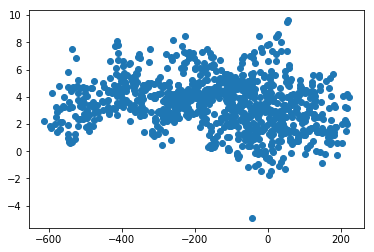

In [332]:
plt.scatter(DT30_fake, DT30_true)